In [150]:
import numpy as np
from scipy.spatial import ConvexHull
from matplotlib.path import Path
from matplotlib import pyplot as plt

def get_cluster_randomized_2d(points):
    ## Function translated by Max Winga and ChatGPT from MATLAB code previously 
    ## written by Ai-Hui Tang, PhD (tangah@ustc.edu.cn), on 12/30/2018.
    ## Link to ChatGPT Conversation:
    ## https://chat.openai.com/share/943e6e3d-a069-4d58-bf42-7ea8ff5a52be

    # Check that points is long enough, else return empty
    if len(points) < 3:
        return np.empty((0, 2)) 
    
    # Calculate the convex hull
    hull = ConvexHull(points)
    hull_path = Path(points[hull.vertices])

    # Generate random points
    min_x, min_y = np.min(points, axis=0)
    max_x, max_y = np.max(points, axis=0)

    num_points = len(points)
    random_points_inside = np.empty((0, 2))

    # Keep generating points until we have enough
    while len(random_points_inside) < num_points:
        remaining_points = num_points - len(random_points_inside)
        random_points = np.column_stack((
            np.random.uniform(min_x, max_x, remaining_points * 10),  # Overgenerate and filter
            np.random.uniform(min_y, max_y, remaining_points * 10)
        ))

        # Filter points inside the convex hull
        inside_hull = hull_path.contains_points(random_points)
        random_points_inside = np.vstack([random_points_inside, random_points[inside_hull]])

    # Adjust the number of points to match the input
    adjusted_random_points = random_points_inside[:num_points]

    return adjusted_random_points

def as_tuple(point):
    return (point[0], point[1])

def find_max_index_above_threshold(arr, threshold):
    low, high = 0, len(arr) - 1
    while low <= high:
        mid = (low + high) // 2
        if arr[mid] > threshold:
            low = mid + 1
        else:
            high = mid - 1
    return high

In [129]:
# Example usage
points = np.random.rand(100, 2)  # Replace with your actual points
randomized_points = get_cluster_randomized_2d(points)
print(len(points))
print(len(randomized_points))


100
100


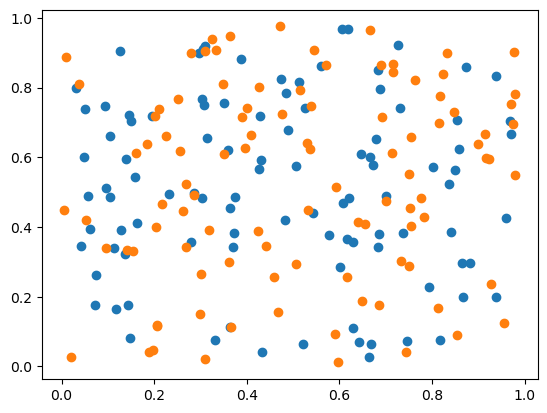

In [130]:
# plt.figure()
# plt.scatter(points[:, 0], points[:, 1])
# plt.show()

plt.figure()
plt.scatter(randomized_points[:, 0], randomized_points[:, 1])
plt.scatter(points[:, 0], points[:, 1])
plt.show()

In [149]:
def distance_squared(points, i1, i2):
    return (points[i1][0] - points[i2][0])**2 + (points[i1][1] - points[i2][1])**2

In [184]:
from scipy.spatial import KDTree
from sklearn.cluster import DBSCAN

def blanpied_clustering(points, density_factor, peak_distance_threshold, min_samples=60,
                        min_cluster_size=3):
    
    # Calculate full_MMD for whole frame
    kdtree = KDTree(points)
    distances, _ = kdtree.query(points, k=2, workers=-1)
    mmd = np.mean(distances[:, 1])
    
    # Use DBSCAN to locate "synaptic clusters" 60 min_samples, 5 * full_MMD eps
    db = DBSCAN(eps=5*mmd, min_samples=min_samples, metric='euclidean', n_jobs=-1).fit(points)
    synaptic_clusters = []
    for label in np.unique(db.labels_):
        if label == -1: continue
        synaptic_clusters.append(np.where(db.labels_ == label)[0])
        
    nanocluster_groups = []
    # For each synaptic cluster
    for synaptic_cluster in synaptic_clusters:
        
        # Calculate local_density_radius
        local_kdtree = KDTree(points[synaptic_cluster])
        local_mmd = np.mean(distances[synaptic_cluster, 1])
        local_density_radius = density_factor * local_mmd

        # Calculate Local Densities using points within local_density_radius
        local_densities = np.array(local_kdtree.query_ball_point(points[synaptic_cluster], local_density_radius, 
                                                                 workers=-1, return_length=True))
        
        # Sort the indices in synaptic_cluster by local_density
        sorted_indices = np.argsort(-local_densities)
        local_densities = local_densities[sorted_indices]
        synaptic_cluster = synaptic_cluster[sorted_indices]

        # Get Randomized Points and Calculate LD0_threshold
        LD0_thresholds = []
        for _ in range(5):
            r_points = get_cluster_randomized_2d(points[synaptic_cluster])
            r_kdtree = KDTree(r_points)
            r_local_densities = np.array(r_kdtree.query_ball_point(r_points, local_density_radius, 
                                                                   workers=-1, return_length=True))
            LD0_thresholds.append(np.mean(r_local_densities) + 4 * np.std(r_local_densities))
        LD0_threshold = np.median(np.array(LD0_thresholds))

        # Find nanoclusters
        max_index = find_max_index_above_threshold(local_densities, LD0_threshold) + 1
        points_over_threshold = points[synaptic_cluster[:max_index]]
        nanoclusters = {}
        nearby_points = np.array(local_kdtree.query_ball_point(points_over_threshold, 
                                                               peak_distance_threshold, 
                                                               workers=-1))
        for i in range(max_index):
            nearby_peaks = [point for point in nearby_points[i] if point in nanoclusters]
            if len(nearby_peaks) == 0:
                nanoclusters[i] = [i]
            else:
                peak_distances = np.array([distance_squared(points_over_threshold, peak, i) for peak in nearby_peaks])
                nearest_peak = nearby_peaks[np.argmin(peak_distances)]
                nanoclusters[nearest_peak].append(i)
        
        final_nanoclusters = {}
        # Filter out Subclusters
        for center in nanoclusters:
            cluster_indices = nanoclusters[center]
            final_indices = np.array([False for i in range(len(cluster_indices))])
            final_indices[center] = True
            to_check = np.array([center])
            while len(to_check) > 0:
                within_range = local_kdtree.query_ball_point(points_over_threshold[to_check], r=2*local_mmd,
                                                             workers=-1)
                to_check = []
                for point_list in within_range:
                    for point in point_list:
                        if not final_indices[point]:
                            final_indices[point] = True
                            to_check.append(point)
            cluster_indices = cluster_indices[final_indices]

            # Discard cluster if small, else update the cluster in final index coords
            if not len(cluster_indices) < min_cluster_size: 
                final_nanoclusters[synaptic_cluster[center]] = [synaptic_cluster[idx] for idx in cluster_indices]

        # Add to nanocluster_groups
        nanocluster_groups.append(final_nanoclusters)
    
    return synaptic_clusters, nanocluster_groups

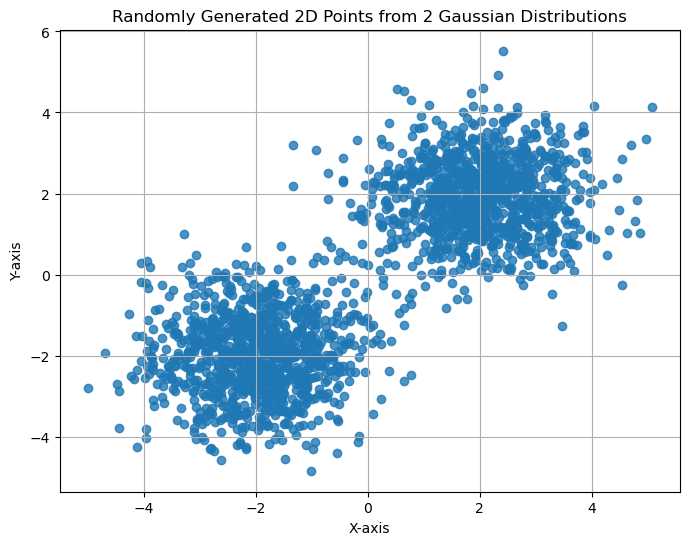

In [185]:
# Parameters for the first Gaussian distribution
mean1 = [2, 2]
cov1 = [[1, 0], [0, 1]]  # Diagonal covariance, points lie on x or y axis

# Parameters for the second Gaussian distribution
mean2 = [-2, -2]
cov2 = [[1, 0], [0, 1]]  # Diagonal covariance

# Generating random samples
num_samples = 1000  # Number of samples from each distribution
data1 = np.random.multivariate_normal(mean1, cov1, num_samples)
data2 = np.random.multivariate_normal(mean2, cov2, num_samples)

# Combining the two datasets
data = np.vstack((data1, data2))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.8)
plt.title('Randomly Generated 2D Points from 2 Gaussian Distributions')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

In [186]:
synaptic_clusters, nanocluster_groups = blanpied_clustering(data, 2, 0.5, 60)

In [196]:
print(nanocluster_groups)

[{}, {}]


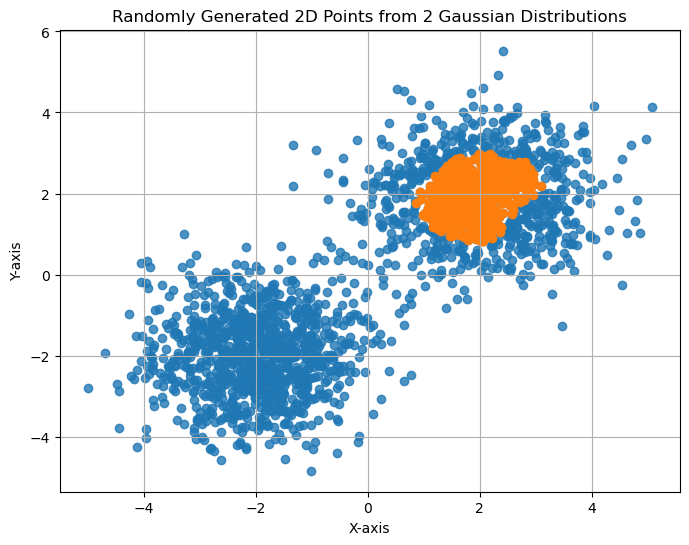

In [192]:
# Plotting
synaptic_cluster = 0
nanocluster = 0
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.8)
plt.scatter(data[synaptic_clusters[synaptic_cluster]][:, 0], data[synaptic_clusters[synaptic_cluster]][:, 1])
plt.title('Randomly Generated 2D Points from 2 Gaussian Distributions')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

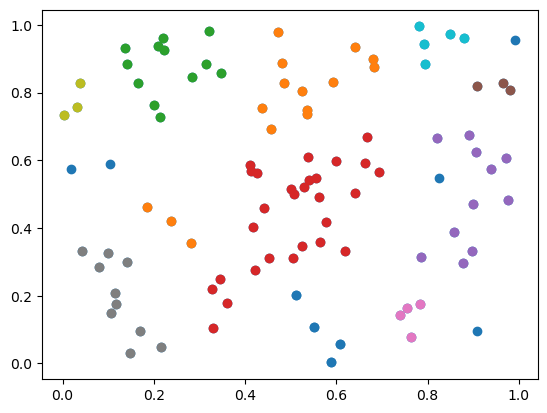

In [87]:
plt.scatter(points[:, 0], points[:, 1])
for label in np.unique(db.labels_):
    if label == -1: continue
    cluster = points[np.where(db.labels_ == label)]
    plt.scatter(cluster[:, 0], cluster[:, 1])

array([[0.5357433 , 0.74966796],
       [0.13693961, 0.93282922],
       [0.01783076, 0.57340536],
       [0.45243177, 0.31286482],
       [0.41244002, 0.56773388],
       [0.22321681, 0.92582151],
       [0.53482798, 0.73633331],
       [0.31321119, 0.88492263],
       [0.52363374, 0.34839768],
       [0.28458342, 0.84516261],
       [0.99240901, 0.95698937],
       [0.94016532, 0.57530586],
       [0.9654225 , 0.82731079],
       [0.73969166, 0.14439431],
       [0.34413697, 0.25051862],
       [0.41651094, 0.40348972],
       [0.09984435, 0.32651307],
       [0.50437122, 0.31086827],
       [0.17040305, 0.09669446],
       [0.42540776, 0.5635    ],
       [0.58758631, 0.00285649],
       [0.53726345, 0.60916977],
       [0.97201476, 0.60719068],
       [0.03061057, 0.75693499],
       [0.75418865, 0.16427071],
       [0.18485632, 0.46195037],
       [0.45733894, 0.69247634],
       [0.79197174, 0.94241412],
       [0.28092733, 0.35459165],
       [0.82465591, 0.54869404],
       [0.